In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time

In [2]:
root_dir = ""


training_data = datasets.MNIST(
	root = root_dir,
	train = True,
	download = True,
	transform = transforms.ToTensor()
)

test_data = datasets.MNIST(
	root = root_dir,
	train = False,
	download = True,
	transform = transforms.ToTensor()
)

In [3]:
training_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: 
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: 
     Split: Test
     StandardTransform
 Transform: ToTensor())

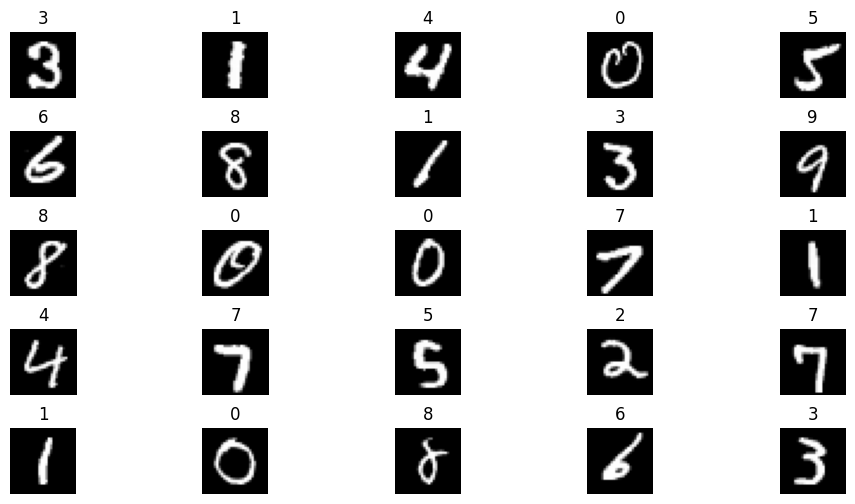

In [4]:
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(12,6))
for i in range(1, rows*cols + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]
	plt.subplot(rows, cols, i)
	plt.title(label)
	plt.imshow(img.squeeze(), cmap="gray")
	plt.axis("off")
plt.subplots_adjust(hspace=0.50)
plt.show()

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


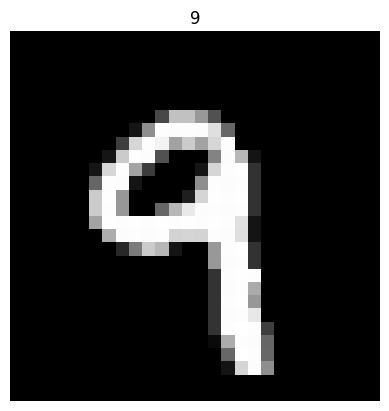

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

#Lets plot the first image in our first iter
img = train_features[0].squeeze()
label = int(train_labels[0])
plt.imshow(img, cmap="gray")
plt.title(label)
plt.axis("off")
plt.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
	def __init__(self):
		super(Net, self).__init__()
		self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
		self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
		self.conv2_drop = nn.Dropout2d()
		self.fc1 = nn.Linear(20*4*4, 50)
		self.fc2 = nn.Linear(50, 10)
	
	def forward(self, x):
		x = F.relu(F.max_pool2d(self.conv1(x), 2))
		x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
		x = x.view(-1, 20*4*4)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.02, momentum=0.8)

In [7]:
from torch.autograd import Variable

def train_model(epochs, model):
	t0 = time()
	print("Started Training ....")
	for epoch in range(epochs):
		running_loss = 0.0
		correct = 0
		total = 0
		for index, data in enumerate(train_dataloader, 0):
			inputs, labels = data
			inputs, labels = Variable(inputs), Variable(labels)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			#Statistics
			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()
			if (index % 300) == 299: # for every 100 mini batches print
					l = running_loss / 300
					a = 100.*(correct/total)
					print(f"Epoch: {epoch + 1}/{epochs}, Batch: {index + 1} => LOSS: {round(l, 5)}, ACCURACY: {round(a, 5)}")
					running_loss = 0.0
	print("Finished Training in %0.3fs"%(time()-t0))

def test_model(model):
	correct = 0
	total = 0
	with torch.no_grad():
			for data in test_dataloader:
					images, labels = data
					outputs = model(images)
					_, predicted = torch.max(outputs.data, 1)
					total += labels.size(0)
					correct += (predicted == labels).sum().item()

	print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [8]:
train_model(epochs=3, model=net)
test_model(model=net)

Started Training ....
Epoch: 1/3, Batch: 300 => LOSS: 1.01099, ACCURACY: 66.50521
Epoch: 1/3, Batch: 600 => LOSS: 0.28006, ACCURACY: 79.11979
Epoch: 1/3, Batch: 900 => LOSS: 0.208, ACCURACY: 84.03819
Epoch: 2/3, Batch: 300 => LOSS: 0.17421, ACCURACY: 94.77604
Epoch: 2/3, Batch: 600 => LOSS: 0.15798, ACCURACY: 95.10938
Epoch: 2/3, Batch: 900 => LOSS: 0.13979, ACCURACY: 95.36111
Epoch: 3/3, Batch: 300 => LOSS: 0.1268, ACCURACY: 96.21354
Epoch: 3/3, Batch: 600 => LOSS: 0.11524, ACCURACY: 96.34375
Epoch: 3/3, Batch: 900 => LOSS: 0.11492, ACCURACY: 96.44792
Finished Training in 70.917s
Accuracy of the network on the 10000 test images: 97 %


In [9]:
class Net2(nn.Module):
	def __init__(self):
		super(Net2, self).__init__()
		self.conv1 = nn.Conv2d(1, 6, kernel_size=7)
		self.conv2 = nn.Conv2d(6, 10, kernel_size=7)
		self.conv2_drop = nn.Dropout2d()
		self.fc1 = nn.Linear(10*2*2, 30)
		self.fc2 = nn.Linear(30, 15)
		self.fc3 = nn.Linear(15, 10)
	
	def forward(self, x):
		x = F.relu(F.max_pool2d(self.conv1(x), 2))
		x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
		x = x.view(-1, 10*2*2)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		x = F.elu(self.fc3(x))
		return x

net_2 = Net2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_2.parameters(), lr=0.02)
train_model(epochs=2, model=net_2)
test_model(model=net_2)

Started Training ....
Epoch: 1/2, Batch: 300 => LOSS: 1.00378, ACCURACY: 66.20833
Epoch: 1/2, Batch: 600 => LOSS: 0.628, ACCURACY: 73.15625
Epoch: 1/2, Batch: 900 => LOSS: 0.59836, ACCURACY: 76.00347
Epoch: 2/2, Batch: 300 => LOSS: 0.54836, ACCURACY: 83.21875
Epoch: 2/2, Batch: 600 => LOSS: 0.53269, ACCURACY: 83.8724
Epoch: 2/2, Batch: 900 => LOSS: 0.53219, ACCURACY: 84.02083
Finished Training in 38.875s
Accuracy of the network on the 10000 test images: 86 %


In [10]:
torch.save(net.state_dict(), "cnn_state.pt")
torch.save(net, "cnn_model.pt")